In [9]:
## Imports
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import wavfile as wv
import torch
import torch.nn as nn
from tqdm import tqdm # progress bar
from audioMNIST import AudioMNIST
from DClassifier import CNN2DAudioClassifier
from torch.utils.data import DataLoader, random_split

In [10]:
file_paths = './data/'

Best k (number of neighbors): {'n_neighbors': 4}
Test Accuracy: 0.9055
Macro F1 Score: 0.9065338103120653


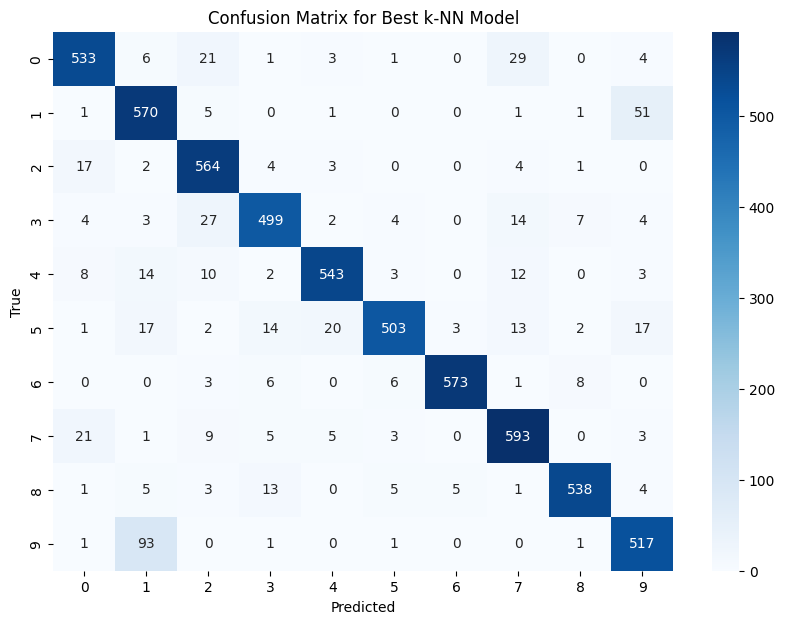

In [13]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader

# Load and prepare data as before
dataset = AudioMNIST()
loader = DataLoader(dataset, batch_size=len(dataset), shuffle=True, num_workers=4)
all_features, all_labels = [], []
for data, target in loader:
    all_features.append(data.numpy())
    all_labels.append(target.numpy())
all_features = np.vstack(all_features).reshape(len(dataset), -1)
all_labels = np.concatenate(all_labels)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.20, random_state=42)

# Setup GridSearchCV to find the best k using cross-validation
param_grid = {'n_neighbors': range(1, 11)}
knn = KNeighborsClassifier(algorithm='brute', weights='distance')
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# Best k and model evaluation
print("Best k (number of neighbors):", grid_search.best_params_)
best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1_score = f1_score(y_test, y_pred, average='macro')
print("Test Accuracy:", test_accuracy)
print("Macro F1 Score:", test_f1_score)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4,5,6,7,8,9], yticklabels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Best k-NN Model')
plt.show()